In [104]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import statsmodels.api as sm
import statsmodels.formula.api as smf

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

import pymc as pm
import aesara.tensor as at
import aesara

In [11]:
data = pd.read_csv("data/Lucia_Poroperm_Male.csv")
data["log_porosity"] = data["Porosity"].apply(np.log).astype(aesara.config.floatX)
data["log_permeability"] = (
    data["Permeability"].apply(np.log).astype(aesara.config.floatX)
)
class_idx, class_id = pd.factorize(data["Class"])
coords = {"Class": class_id, "obs_id": np.arange(len(class_idx))}

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_permeability   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     174.2
Date:                Mon, 21 Aug 2023   Prob (F-statistic):          1.03e-100
Time:                        23:14:55   Log-Likelihood:                -702.39
No. Observations:                 433   AIC:                             1417.
Df Residuals:                     427   BIC:                             1441.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     14.4995      0.765     18.964      0.000      12.997      16.002
C(Class)[T.2]                 -3.1086      0.955     -3.256      0.001      -4.985      -1.232
C(Class)[T.3]                 -7.7745      0.859     -9.052      0.000      -9.463      -6.086
log_porosity                   5.0948      0.335     15.211      0.000       4.436       5.753
log_porosity:C(Class)[T.2]    -0.3201      0.436     -0.734      0.463      -1.178       0.537
log_porosity:C(Class)[T.3]    -1.6958      0.410     -4.141      0.000      -2.501      -0.891
==============================================================================
Omnibus:                        3.915   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.852
Skew:                           0.231   Prob(JB):                        0.146
Kurtosis:                       3.001   Cond. No.                         62.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

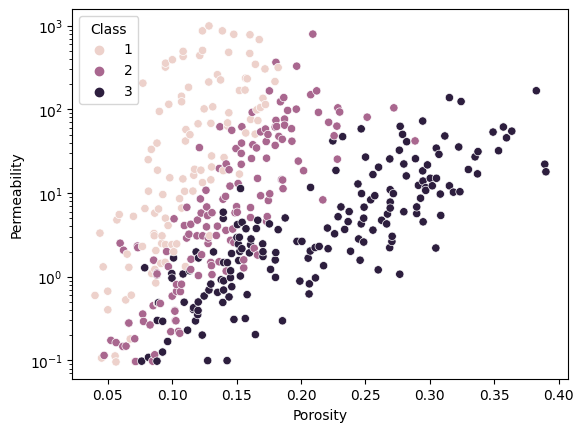

In [159]:
# sns.scatterplot(data, x="log_porosity", y="log_permeability", hue="Class")
g = sns.scatterplot(data, x="Porosity", y="Permeability", hue="Class")
g.set(yscale="log")
ols = smf.ols(formula="log_permeability ~ log_porosity * C(Class)", data=data)
ols.fit().summary()

In [202]:
with pm.Model(coords=coords) as model:
    # Intercepts
    mu_a = pm.Normal("mu_a", mu=11.0, sigma=2)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    a = pm.Normal("a", dims="Class") * sigma_a + mu_a

    # Slopes, non-centered
    mu_b = pm.Normal("mu_b", mu=5.0, sigma=2.0)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)
    b = pm.Normal("b", dims="Class") * sigma_b + mu_b

    eps = pm.HalfNormal("eps", 3.0)

    log_perm_est = a[class_idx] + b[class_idx] * data["log_porosity"].values

    log_perm_like = pm.Normal(
        "log_perm_like",
        mu=log_perm_est,
        sigma=eps,
        observed=data["log_permeability"],
        dims="obs_id",
    )
    idata = pm.sample(target_accept=0.9)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a, mu_b, sigma_b, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [log_perm_like]


array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

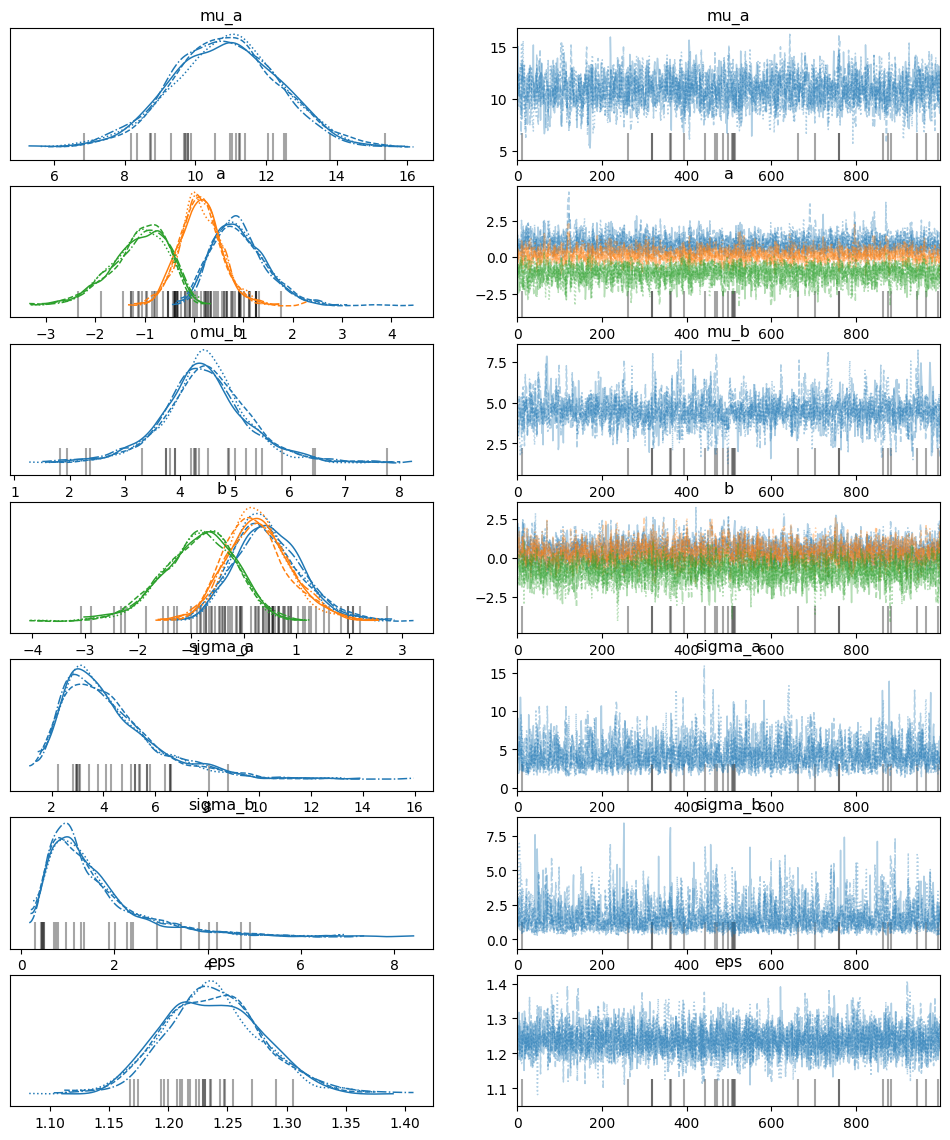

In [203]:
az.plot_trace(idata)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

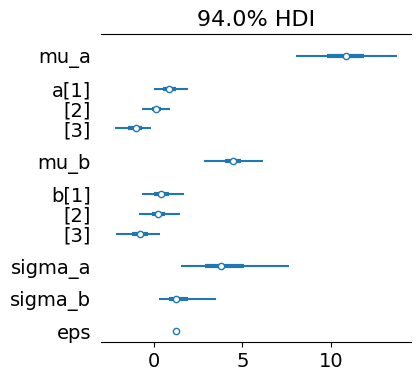

In [204]:
az.plot_forest(
    idata,
    combined=True,
    figsize=(4, 4),
)

<Axes: xlabel='log_perm_like / log_perm_like'>

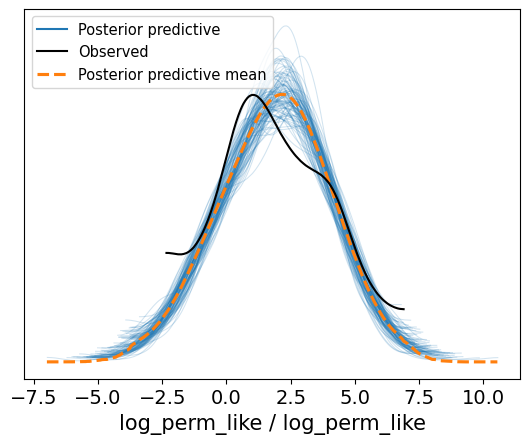

In [205]:
az.plot_ppc(idata, num_pp_samples=100)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

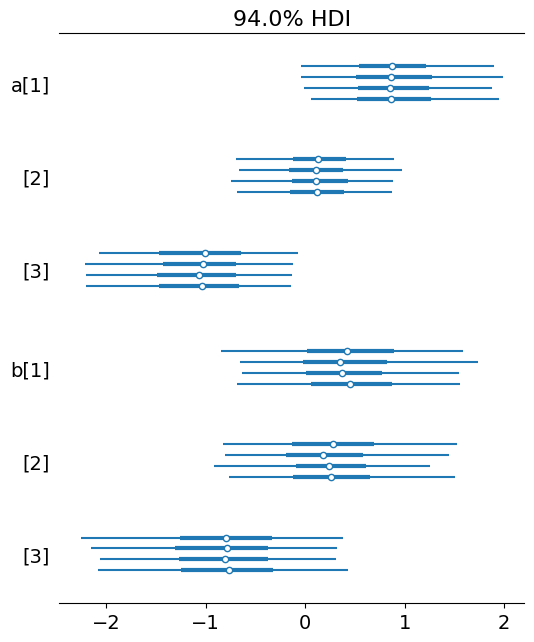

In [206]:
az.plot_forest(idata, var_names=["a", "b"])

<Axes: >

/home/frank/Dropbox/ROZ/code/lucia_bayes/.direnv/python-3.11/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/frank/Dropbox/ROZ/code/lucia_bayes/.direnv/python-3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


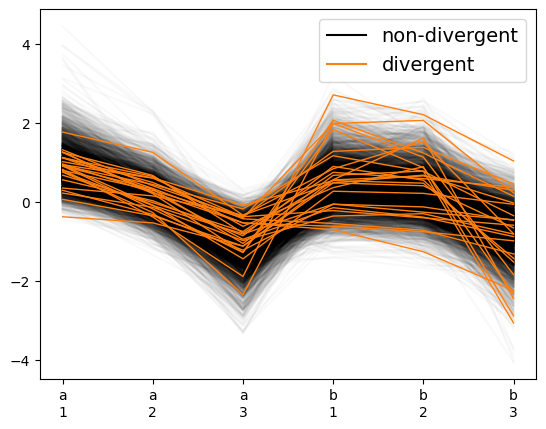

In [207]:
az.plot_parallel(idata, var_names=["a", "b"])

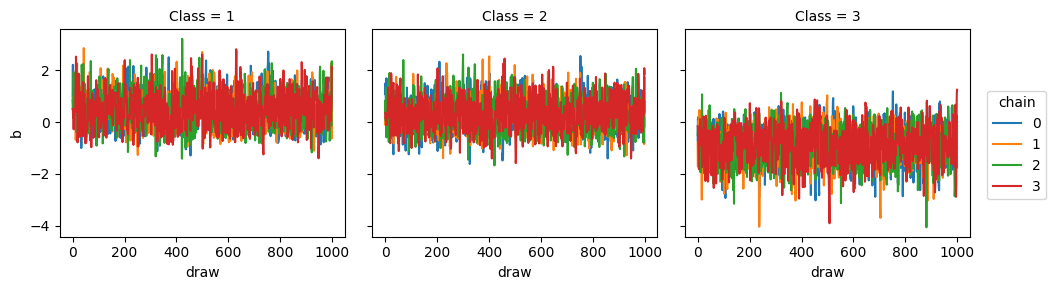

In [208]:
# for class_id in [1,2,3]:
# plt.hist(idata.posterior["b"].sel(Class=class_id), bins=np.linspace(-4,4))
idata.posterior["b"].plot.line(x="draw", col="Class")

In [222]:
log_porosity = np.random.normal(
    data["log_porosity"].mean(),
    data["log_porosity"].std(),
    size=idata.posterior["mu_a"].shape,
)

data_ppc = (
    pd.concat(
        [
            pd.DataFrame(
                {
                    "log_porosity": log_porosity.ravel(),
                    "Class": class_id,
                    "y_pred": (
                        idata.posterior["mu_a"]
                        + idata.posterior["a"].sel(Class=class_id)
                        * idata.posterior["sigma_a"]
                        + (
                            idata.posterior["mu_b"]
                            + idata.posterior["b"].sel(Class=class_id)
                            * idata.posterior["sigma_b"]
                        )
                        * log_porosity
                    )
                    .to_numpy()
                    .ravel(),
                }
            )
            for class_id in range(1, 4)
        ]
    )
    .assign(
        y_like=lambda x: x.y_pred
        * np.random.normal(
            loc=1, scale=np.repeat(idata.posterior["eps"].to_numpy().ravel(), 3)
        )
    )
    .assign(
        porosity=lambda x: np.exp(x.log_porosity),
        permeability=lambda x: np.exp(x.y_pred),
        permeability_like=lambda x: np.exp(x.y_like),
    )
)

[None,
 (0.0, 0.5),
 Text(0, 0.5, 'Permeability with modeled noise'),
 (1e-06, 1000000.0)]

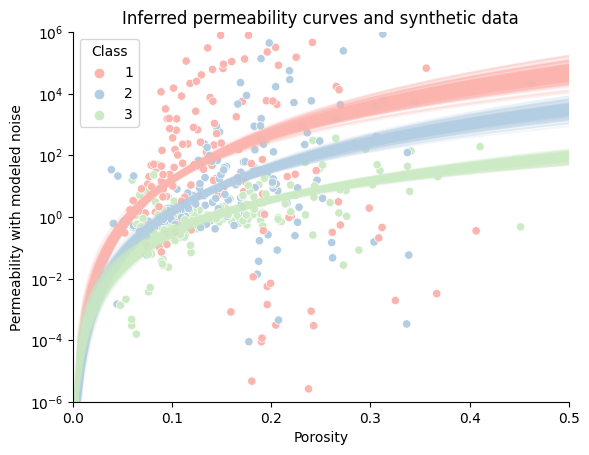

<Figure size 640x480 with 0 Axes>

In [274]:
posterior = idata.posterior

fig, ax = plt.subplots()
porosity = np.linspace(0.001, 0.5, 100)
for class_id in [1, 2, 3]:
    intercept = (
        (posterior["mu_a"] + posterior["a"].sel(Class=class_id) * posterior["sigma_a"])
        .to_numpy()
        .ravel()
    )
    slope = (
        (posterior["mu_b"] + posterior["b"].sel(Class=class_id) * posterior["sigma_b"])
        .to_numpy()
        .ravel()
    )
    for i in np.random.choice(range(len(slope)), 200):
        permeability = np.exp(intercept[i] + slope[i] * np.log(porosity))
        ax.plot(
            porosity,
            permeability,
            color=sns.color_palette("Pastel1")[class_id - 1],
            alpha=0.15,
        )
ax.set(
    yscale="log",
    xlabel="Porosity",
    ylabel="Permeability",
    title="Inferred permeability curves and synthetic data",
)
sns.despine()

plt.figure()
g2 = sns.scatterplot(
    data=data_ppc.sample(500),
    x="porosity",
    y="permeability_like",
    hue="Class",
    palette="Pastel1",
    ax=ax,
)
g2.set(
    yscale="log",
    xlim=(0, 0.5),
    ylabel="Permeability with modeled noise",
    ylim=(1e-6, 1e6),
)
# sns.despine()

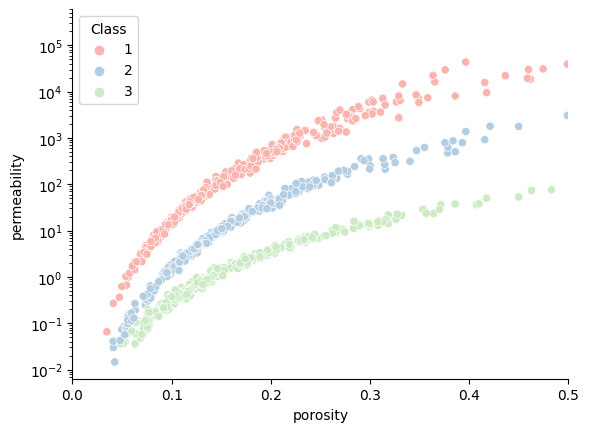

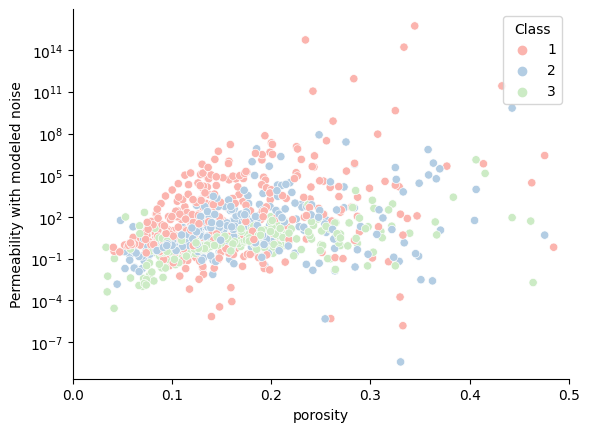

In [224]:
g = sns.scatterplot(
    data=data_ppc.sample(1000),
    x="porosity",
    y="permeability",
    hue="Class",
    palette="Pastel1",
)
g.set(yscale="log", xlim=(0, 0.5))
sns.despine()

plt.figure()
g2 = sns.scatterplot(
    data=data_ppc.sample(1000),
    x="porosity",
    y="permeability_like",
    hue="Class",
    palette="Pastel1",
)
g2.set(yscale="log", xlim=(0, 0.5), ylabel="Permeability with modeled noise")
sns.despine()

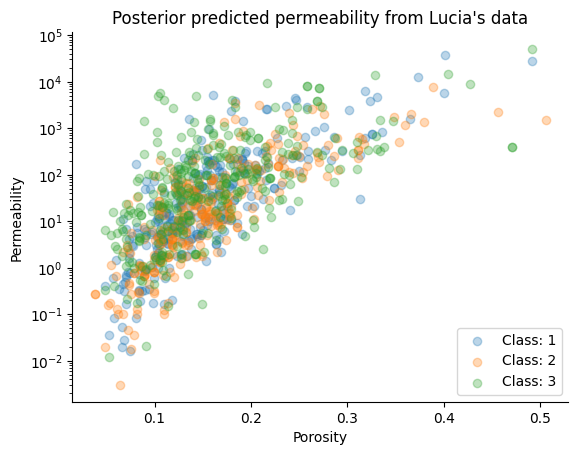

In [167]:
# log_porosity = np.linspace([-3.5] * 4, [-1] * 4, idata.posterior["mu_a"].shape[1]).T
log_porosity = np.random.normal(
    data["log_porosity"].mean(),
    data["log_porosity"].std(),
    size=idata.posterior["mu_a"].shape,
)
fig, ax = plt.subplots()
rng = np.random.default_rng(42)
for class_id in range(1, 4):
    y_pred = (
        idata.posterior["mu_a"]
        + idata.posterior["a"].sel(Class=class_id)
        + (idata.posterior["mu_b"] + idata.posterior["b"].sel(Class=class_id))
        * log_porosity
    )
    index = rng.choice(np.arange(y_pred.shape[1]), 75)
    ax.scatter(
        np.exp(log_porosity[:, index]),
        np.exp(y_pred[:, index]),
        alpha=0.3,
        label=f"Class: {class_id}",
    )
ax.legend(loc="lower right")
ax.set(
    xlabel="Porosity",
    ylabel="Permeability",
    yscale="log",
    title="Posterior predicted permeability from Lucia's data",
)
sns.despine()